In [331]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from os.path import exists, join
from marbleri.nwp import BestTrackNetCDF
from marbleri.process import get_hwrf_filenames_diff, get_var_levels, load_hwrf_data_distributed, \
    normalize_hwrf_loaded_data, discretize_output, scaler_classes
from matplotlib.colors import LogNorm
from os import makedirs
from glob import glob

## HWRF ML Model Evaluation
The goal of this notebook is to generate verification plots from the train_hwrf_ml.py script results. The script outputs a set of csv files with model predictions and summary statistics.

In [386]:
# load yaml config file
def read_config(config_file):
    with open(config_file, "r") as config_obj:
        config = yaml.load(config_obj, Loader=yaml.Loader)
    return config

config_files = {"2019": "/glade/u/home/dgagne/marbleri/config/hwrf_train_2019.yml",
                "2020": "/glade/u/home/dgagne/marbleri/config/hwrf_train_2020_leaky.yml"}
config = {}
for year, cfile in config_files.items():
    config[year] = read_config(cfile)



In [387]:
year = "2020"
data_modes = config[year]["data_modes"]
conv_subset = config[year]["conv_inputs"]["subset"]
out_path = config[year]["out_path"]
best_track_nc = {}
best_track_df = {}
dt = config[year]["time_difference_hours"]
best_track_inputs_dt = [f"{bt}_dt_{dt:d}" for bt in config[year]["best_track_inputs"]]
best_track_input_norm = {}
output_field = config[year]["best_track_output"] + f"_dt_{dt:d}"
hwrf_field_data = {}
hwrf_norm_data = {}
output_bins = np.arange(config[year]["output_bins"][0],
                        config[year]["output_bins"][1] + config[year]["output_bins"][2],
                        config[year]["output_bins"][2])
best_track_output_discrete = {}
best_track_meta = {}
best_track_scaler = scaler_classes[config[year]["best_track_scaler"]]()
conv_scale_values = None
for mode in data_modes:
    print("Loading " + mode)
    best_track_nc[mode] = BestTrackNetCDF(**config[year]["best_track_data_paths"][mode])
    best_track_nc[mode].calc_time_differences(config[year]["best_track_inputs"], config[year]["time_difference_hours"])
    best_track_nc[mode].calc_time_differences([config[year]["best_track_output"]], config[year]["time_difference_hours"])
    best_track_df[mode] = best_track_nc[mode].to_dataframe(best_track_inputs_dt + [output_field])
    all_meta_columns = best_track_nc[mode].run_columns + best_track_nc[mode].meta_columns
    best_track_meta[mode] = best_track_df[mode][all_meta_columns]                                                                    
    if mode == "train":                                                                                                              
        best_track_input_norm[mode] = pd.DataFrame(best_track_scaler.fit_transform(                                                  
            best_track_df[mode][best_track_inputs_dt]), columns=best_track_inputs_dt)                                                
    else:                                                                                                                            
        best_track_input_norm[mode] = pd.DataFrame(best_track_scaler.transform(                                                      
            best_track_df[mode][best_track_inputs_dt]), columns=best_track_inputs_dt)                                                
    best_track_output_discrete[mode] = discretize_output(best_track_df[mode][output_field].values, output_bins)

Loading train
<xarray.DataArray 'run' (run: 690)>
array([  0,   1,   2, ..., 687, 688, 689])
Dimensions without coordinates: run
Loading val
<xarray.DataArray 'run' (run: 1090)>
array([   0,    1,    2, ..., 1087, 1088, 1089])
Dimensions without coordinates: run
Loading test
<xarray.DataArray 'run' (run: 1090)>
array([   0,    1,    2, ..., 1087, 1088, 1089])
Dimensions without coordinates: run


In [333]:
best_track_df["val"]

DATE   STNAM STNUM BASIN  TIME         LON        LAT  \
run time                                                                
0   8     2018082518  invest    15     e    24  234.300003  13.200000   
    9     2018082518  invest    15     e    27  233.699997  13.300000   
    10    2018082518  invest    15     e    30  233.300003  13.300000   
    11    2018082518  invest    15     e    33  232.199997  13.600000   
    12    2018082518  invest    15     e    36  231.199997  13.500000   
...              ...     ...   ...   ...   ...         ...        ...   
638 28    2018103112   oscar    16     l    84  345.100006  59.700001   
    29    2018103112   oscar    16     l    87  346.000000  60.500000   
    30    2018103112   oscar    16     l    90  346.899994  61.200001   
    31    2018103112   oscar    16     l    93  348.100006  61.900002   
    32    2018103112   oscar    16     l    96  349.399994  62.900002   

            STM_SPD     STM_HDG         LAND  ...  TANG850_dt_24  \
run time                                      ...                  
0   8      9.785027  275.865051  1908.829956  ...       0.220001   
    9      9.785027  275.865051  1948.150024  ...      -1.919998   
    10    14.893866  281.619659  1980.050049  ...       4.500000   
    11    20.526024  275.590942  2048.060059  ...      -0.090000   
    12    16.070105  255.587662  2139.290039  ...      -3.220001   
...             ...         ...          ...  ...            ...   
638 28    17.272697   29.723915   565.080017  ...     -65.600006   
    29    17.430017   30.617512   550.429993  ...     -62.210007   
    30    17.272854   35.852898   542.570007  ...     -57.830002   
    31    20.647058   34.576992   536.590027  ...     -62.270004   
    32    24.755123   27.288963   576.010010  ...     -68.509995   

          VORT850_dt_24  DVRG200_dt_24  STM_SPD_dt_24  RHLO_dt_24  RHMD_dt_24  \
run time                                                                        
0   8         -0.900002     -62.650002      -4.441219   24.880005  -61.949951   
    9         13.660000     -29.320002      -1.126534    8.869995  -72.010010   
    10        19.000000      -5.920000       5.146253    8.119995  -73.119995   
    11        28.570000      12.750000      12.175135   27.950012  -46.149963   
    12        32.970001       0.290001       7.696227   35.180054  -27.950012   
...                 ...            ...            ...         ...         ...   
638 28       -68.910004     -23.849998     -12.348543   66.309998   67.519958   
    29       -80.439972     -21.860001     -13.649157   47.229980   20.690002   
    30      -100.529999      -9.840000     -13.551556   24.140015  -22.719971   
    31      -122.010010      -1.139999      -5.937548    8.079956  -47.309998   
    32      -145.139984      -2.119995       3.262478    4.219971  -49.130005   

          RHHI_dt_24  INST1_dt_24  INST2_dt_24  vmax_bt_dt_24  
run time                                                       
0   8     -61.149963         0.32         0.12           15.0  
    9     -62.140015        -0.06        -0.03           15.0  
    10    -40.970032        -0.03        -0.09           15.0  
    11     -7.529968        -1.04        -0.35           17.5  
    12      7.640015        -0.14         0.06           20.0  
...              ...          ...          ...            ...  
638 28     49.000000        -4.26        -1.87          -25.0  
    29     12.959991        -3.51        -1.76          -25.0  
    30    -25.290009        -1.98        -1.14          -25.0  
    31    -42.459991        -2.54        -1.08          -20.0  
    32    -27.429993        -2.34        -1.04          -15.0  

[15063 rows x 27 columns]

In [18]:
config["2019"]

{'data_modes': ['train', 'val', 'test'],
 'hwrf_data_paths': {'train': '/glade/p/ral/nsap/rozoff/hfip/reforecast_h218_rotated/',
  'val': '/glade/p/ral/nsap/rozoff/hfip/realtime2018_h218_rotated/',
  'test': '/glade/p/ral/nsap/rozoff/hfip/realtime2019_h218_rotated/'},
 'best_track_data_paths': {'train': {'file_path': '/glade/p/cisl/aiml/dgagne/besttrack_predictors/',
   'file_start': 'diag_2015_2017',
   'start_date': '2015-01-01',
   'end_date': '2017-12-31'},
  'val': {'file_path': '/glade/p/cisl/aiml/dgagne/besttrack_predictors/',
   'file_start': 'diag_2018',
   'start_date': '2018-01-01',
   'end_date': '2018-12-31'},
  'test': {'file_path': '/glade/p/cisl/aiml/dgagne/besttrack_predictors/',
   'file_start': 'diag_2019',
   'start_date': '2019-01-01',
   'end_date': '2019-12-31'}},
 'time_difference_hours': 24,
 'conv_inputs': {'variables': ['THETA_E', 'U_RAD', 'V_TAN'],
  'levels': [20000, 50000, 85000, 'surface'],
  'scale_format': 'standard',
  'subset': [15, 111]},
 'best_trac

In [5]:
ls /glade/scratch/dgagne/hwrf_2019_output

conv_discrete.h5
conv_discrete_test_discrete_predictions.csv
conv_discrete_test_discrete_scores.csv
conv_discrete_test_linear_scores.csv
conv_discrete_train_discrete_predictions.csv
conv_discrete_train_discrete_scores.csv
conv_discrete_train_linear_scores.csv
conv_discrete_val_discrete_predictions.csv
conv_discrete_val_discrete_scores.csv
conv_discrete_val_linear_scores.csv
conv_linear.h5
conv_linear_test_linear_predictions.csv
conv_linear_test_linear_scores.csv
conv_linear_train_linear_predictions.csv
conv_linear_train_linear_scores.csv
conv_linear_val_linear_predictions.csv
conv_linear_val_linear_scores.csv
conv_mixed.h5
conv_mixed_test_discrete_predictions.csv
conv_mixed_test_discrete_scores.csv
conv_mixed_test_linear_scores.csv
conv_mixed_train_discrete_predictions.csv
conv_mixed_train_discrete_scores.csv
conv_mixed_train_linear_scores.csv
conv_mixed_val_discrete_predictions.csv
conv_mixed_val_discrete_scores.csv
conv_mixed_val_linear_scores.csv
dense_neural_net_discrete.h5
dense_n

In [388]:
year = "2020"
out_path = config[year]["out_path"]
data_modes = config[year]["data_modes"]
models = list(config[year]["models"].keys())
linear_scores = {}
discrete_scores = {}
for mode in data_modes:
    linear_scores[mode] = {}
    discrete_scores[mode] = {}
    for model in models:
        linear_score_file = join(out_path, f"{model}_{mode}_linear_scores.csv")
        discrete_score_file = join(out_path, f"{model}_{mode}_discrete_scores.csv")
        linear_scores[mode][model] = pd.read_csv(linear_score_file, index_col="subset")
        if exists(discrete_score_file):
            discrete_scores[mode][model] = pd.read_csv(discrete_score_file, index_col="subset")

In [114]:
basins = linear_scores["test"][models[0]].index[1:].str.split("_").str[0].unique()
basins


Index(['e', 'l', 'w'], dtype='object', name='subset')

In [118]:
long_basin_names = {"l": "Atlantic", "e": "East Pacific", "w": "Northwest Pacific"}

In [30]:
linear_scores["test"]["random_forest_linear"].index[1:].str.split("_").str[1]

Index(['f024', 'f027', 'f030', 'f033', 'f036', 'f039', 'f042', 'f045', 'f048',
       'f051', 'f054', 'f057', 'f060', 'f063', 'f066', 'f069', 'f072', 'f075',
       'f078', 'f081', 'f084', 'f087', 'f090', 'f093', 'f096', 'f099', 'f102',
       'f105', 'f108', 'f111', 'f114', 'f117', 'f120', 'f123', 'f126', 'f024',
       'f027', 'f030', 'f033', 'f036', 'f039', 'f042', 'f045', 'f048', 'f051',
       'f054', 'f057', 'f060', 'f063', 'f066', 'f069', 'f072', 'f075', 'f078',
       'f081', 'f084', 'f087', 'f090', 'f093', 'f096', 'f099', 'f102', 'f105',
       'f108', 'f111', 'f114', 'f117', 'f120', 'f123', 'f126'],
      dtype='object', name='subset')

In [389]:
def plot_str_bottom(x, y, ax, text_properties):
    y_bot = ax.get_ylim()[0]
    if y_bot < 0:
        y_bot_new = y_bot * 0.95
    else:
        y_bot_new = y_bot * 1.15
    for i, xi in enumerate(x):
        ax.text(xi, y_bot_new, f"{int(y[i]):d}", **text_properties, ha="left", va="center")

In [390]:

if not exists(join(out_path, "plots")):
    makedirs(join(out_path, "plots"))
for mode in ["val", "test"]:
    basins = linear_scores[mode][models[0]].index[1:].str.split("_").str[0].unique()
    metrics = linear_scores[mode][models[0]].columns[:-1]
    for metric in metrics:
        fig, axes = plt.subplots(len(basins), 1, figsize=(10, 6 * len(basins)))
        for a, ax in enumerate(axes):
            for model in models:
                idxs = linear_scores[mode][model][metric].index.str[0] == basins[a]
                f_hour_str = linear_scores[mode][model][metric].index[idxs].str.split("_").str[1]
                f_hour = f_hour_str.str[1:].astype(int)
                ax.plot(f_hour, linear_scores[mode][model][metric][idxs], label=model.replace("_", " "))
                ax.set_xlabel("Forecast Hour", fontsize=14)
                ax.set_ylabel(f"{long_basin_names[basins[a]]} {mode.capitalize()} {metric.replace('_', ' ')}", fontsize=14)
            
            old_y_lim = ax.get_ylim()
            ax.set_ylim(old_y_lim[0] * 0.9, old_y_lim[1] * 1.10)
            ax.legend(loc="upper right", ncol=4)

            plot_str_bottom(f_hour, linear_scores[mode][model]["Count"][idxs].values, ax, {"fontsize":8, "rotation": 90})
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_linear_{metric}_fhours.png"), dpi=250, bbox_inches="tight")
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_linear_{metric}_fhours.pdf"), dpi=250, bbox_inches="tight")
        plt.close()

In [391]:

if not exists(join(out_path, "plots")):
    makedirs(join(out_path, "plots"))
for mode in ["val", "test"]:
    basins = discrete_scores[mode][models[1]].index[1:].str.split("_").str[0].unique()
    metrics = discrete_scores[mode][models[1]].columns[:-1]
    for metric in metrics:
        fig, axes = plt.subplots(len(basins), 1, figsize=(10, 6 * len(basins)))
        for a, ax in enumerate(axes):
            for model in discrete_scores[mode].keys():
                idxs = (discrete_scores[mode][model][metric].index.str[0] == basins[a]) & (~np.isnan(discrete_scores[mode][model][metric]))
                f_hour_str = discrete_scores[mode][model][metric].index[idxs].str.split("_").str[1]
                f_hour = f_hour_str.str[1:].astype(int)
                ax.plot(f_hour, discrete_scores[mode][model][metric][idxs], label=model.replace("_", " "))
                ax.set_xlabel("Forecast Hour", fontsize=14)
                ax.set_ylabel(f"{long_basin_names[basins[a]]} {mode.capitalize()} {metric.replace('_', ' ')}", fontsize=14)
            old_y_lim = ax.get_ylim()
            ax.set_ylim(old_y_lim[0] * 0.9, old_y_lim[1] * 1.10)
            ax.legend(loc="upper right", ncol=4)

            plot_str_bottom(f_hour, discrete_scores[mode]["resnet_discrete"]["Count"][idxs].values, ax, {"fontsize":8, "rotation": 90})
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_discrete_{metric}_fhours.png"), dpi=250, bbox_inches="tight")
        plt.savefig(join(out_path, "plots", f"{mode}_{year}_discrete_{metric}_fhours.pdf"), dpi=250, bbox_inches="tight")
        plt.close()

In [392]:
predictions = {}
for mode in ["train", "val", "test"]:
    predictions[mode] = {}
    for model in config[year]["models"].keys():
        output_type = config[year]["models"][model]["output_type"]
        predictions[mode][model] = pd.read_csv(join(out_path, f"{model}_{mode}_{output_type}_predictions.csv"))

In [407]:
model_name = "conv_discrete"
d_mode = "val"
predictions[d_mode][model_name][predictions[d_mode][model_name]["STNAM"] == "dorian"].run.unique()

array([372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
       385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
       398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410,
       411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
       424, 425, 426])

In [404]:
predictions["val"]["conv_discrete"]["STNAM"].unique().size

57

In [366]:
predictions[d_mode][model_name][predictions[d_mode][model_name]["STNAM"] == "michael"].columns

Index(['run', 'time', 'DATE', 'STNAM', 'STNUM', 'BASIN', 'TIME', 'LON', 'LAT',
       'STM_SPD', 'STM_HDG', 'LAND', 'resnet_discrete_40',
       'resnet_discrete_35', 'resnet_discrete_30', 'resnet_discrete_25',
       'resnet_discrete_20', 'resnet_discrete_15', 'resnet_discrete_10',
       'resnet_discrete_05', 'resnet_discrete_00', 'resnet_discrete_-5',
       'resnet_discrete_-10', 'resnet_discrete_-15', 'resnet_discrete_-20',
       'resnet_discrete_-25', 'resnet_discrete_-30', 'resnet_discrete_-35',
       'resnet_discrete_-40', 'vmax_bt_dt_24', 'resnet_discrete'],
      dtype='object')

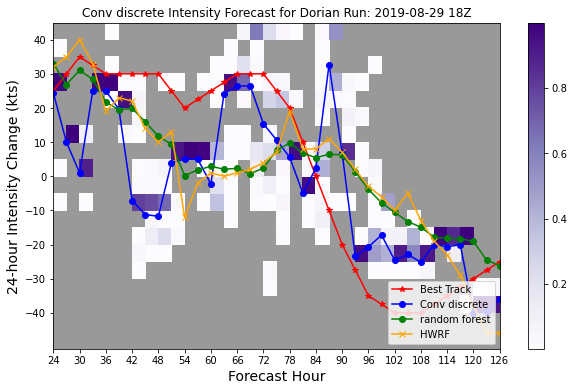

In [414]:
run_id = 391
idx = predictions[d_mode][model_name].run == run_id
fancy_model_name = model_name.replace("_", " ").capitalize()
all_columns = predictions[d_mode][model_name][idx].columns
pred_columns = all_columns[all_columns.str.contains(model_name + "_")][::-1]
intensity_bins = pred_columns.str.split("_").str[-1].values.astype(int)
f_hour = predictions[d_mode][model_name][idx]["TIME"]
preds = predictions[d_mode][model_name][idx][pred_columns].T.values
fig = plt.figure(figsize=(10, 6))
plt.pcolormesh(f_hour, np.arange(-40, 50, 5), np.ma.array(preds, mask=preds<1e-3), cmap="Purples")
plt.plot(f_hour, np.maximum(predictions[d_mode][model_name][idx]["vmax_bt_dt_24"], -40), 'r*-', label="Best Track")
plt.plot(f_hour, predictions[d_mode][model_name][idx][model_name], 'bo-', label=f"{fancy_model_name}")
plt.plot(f_hour, predictions[d_mode]["random_forest_linear"][idx]["random_forest_linear"], 'go-', label="random forest")
plt.plot(best_track_df[d_mode].loc[run_id]["TIME"], best_track_df[d_mode].loc[run_id]["VMAX_dt_24"], color="orange", marker='x', label="HWRF")
plt.gca().set_facecolor("0.6")
plt.xticks(np.arange(f_hour.min(), f_hour.max() + 6, 6))
plt.yticks(np.arange(-40, 50, 10))
plt.ylabel("24-hour Intensity Change (kts)", fontsize=14)
plt.xlabel("Forecast Hour", fontsize=14)
plt.legend(loc="lower right")
storm_name = predictions[d_mode][model_name][idx]["STNAM"].iloc[0].capitalize()
init_date = pd.Timestamp(str(predictions[d_mode][model_name][idx]["DATE"].iloc[0]) + "00" ).strftime("%Y-%m-%d %HZ")

plt.title(f"{fancy_model_name} Intensity Forecast for {storm_name} Run: {init_date}", fontsize=12)
plt.colorbar()

In [363]:
best_track_df["test"]["STNAM"].unique()

array(['invest', 'one', 'alvin', 'barbara', 'six', 'erick', 'seven',
       'flossie', 'juliette', 'twelve', 'thirteen', 'kiko', 'fourteen',
       'mario', 'lorena', 'sixteen', 'narda', 'eighteen', 'octave',
       'twenty', 'raymond', 'andrea', 'two', 'barry', 'chantal', 'five',
       'dorian', 'eight', 'gabrielle', 'nine', 'humberto', 'ten', 'jerry',
       'karen', 'lorenzo', 'melissa', 'fifteen', 'nestor', 'olga',
       'pablo', 'rebekah', 'sebastien', 'four', 'francisco', 'lekima',
       'eleven', 'krosa', 'podul', 'faxai', 'hagibis', 'neoguri',
       'bualoi', 'matmo', 'halong', 'fengshen', 'kalmaegi', 'kammuri'],
      dtype=object)

In [340]:
best_track_df[mode].loc[run_id].columns

Index(['DATE', 'STNAM', 'STNUM', 'BASIN', 'TIME', 'LON', 'LAT', 'STM_SPD',
       'STM_HDG', 'LAND', 'RMW_dt_24', 'VMAX_dt_24', 'MIN_SLP_dt_24',
       'SHR_MAG_dt_24', 'SST_dt_24', 'LAND_dt_24', 'TPW_dt_24',
       'TANG850_dt_24', 'VORT850_dt_24', 'DVRG200_dt_24', 'STM_SPD_dt_24',
       'RHLO_dt_24', 'RHMD_dt_24', 'RHHI_dt_24', 'INST1_dt_24', 'INST2_dt_24',
       'vmax_bt_dt_24'],
      dtype='object')

In [281]:
preds.sum(axis=0)

array([1.00000005, 1.        , 1.00000003, 1.0000001 , 1.00000003,
       1.00000008, 0.99999996, 0.99999994, 1.00000004, 0.99999999,
       1.00000003, 1.00000004, 1.00000002, 0.99999999, 1.        ,
       1.00000003, 1.00000003, 0.99999991, 0.99999991, 0.99999999,
       1.00000013, 1.00000006, 0.99999999, 1.00000005, 0.99999992,
       1.00000001, 1.00000001, 0.99999998, 1.00000001, 0.99999996,
       1.        , 0.99999989, 1.00000003, 1.00000008, 1.00000012])

In [326]:
predictions[d_mode][model_name][idx]

,run,time,DATE,STNAM,STNUM,BASIN,TIME,LON,LAT,STM_SPD,...,resnet_discrete_-5,resnet_discrete_-10,resnet_discrete_-15,resnet_discrete_-20,resnet_discrete_-25,resnet_discrete_-30,resnet_discrete_-35,resnet_discrete_-40,vmax_bt_dt_24,resnet_discrete
6918,310,8,2018090912,florence,6,l,24,300.5,24.8,9.136323,...,5.082225e-02,2.858138e-06,2.069555e-04,1.011028e-02,1.507508e-06,1.494529e-08,8.170640e-08,8.378628e-08,40.0,9.023914
6919,310,9,2018090912,florence,6,l,27,300.0,24.8,9.550198,...,1.018607e-08,5.088286e-12,5.808260e-11,5.586282e-07,1.203800e-09,1.140626e-10,2.992644e-10,3.110311e-09,45.0,38.538195
6920,310,10,2018090912,florence,6,l,30,299.5,25.1,10.741969,...,5.870214e-08,1.822975e-10,2.447760e-08,2.569268e-06,1.706163e-07,4.542316e-11,3.402351e-10,2.794806e-08,50.0,35.866520
6921,310,11,2018090912,florence,6,l,33,298.9,25.2,11.040693,...,2.400595e-07,3.184369e-09,3.980854e-08,3.736891e-05,1.211113e-05,1.969987e-10,4.220269e-09,9.722698e-09,42.5,38.907640
6922,310,12,2018090912,florence,6,l,36,298.3,25.3,11.251659,...,9.421868e-06,9.719740e-07,4.039624e-06,3.309537e-05,4.411082e-05,7.778676e-09,1.271129e-06,6.430096e-08,35.0,39.712112
6923,310,13,2018090912,florence,6,l,39,297.7,25.5,12.396579,...,1.016248e-04,6.876435e-05,8.860808e-06,2.342707e-04,8.491041e-04,3.942620e-08,1.826924e-06,2.143900e-08,30.0,39.762454
6924,310,14,2018090912,florence,6,l,42,297.0,25.7,14.406004,...,1.830927e-03,1.835037e-05,5.806758e-06,4.211789e-04,1.271211e-03,5.265727e-06,3.043981e-07,2.165755e-07,25.0,38.884721
6925,310,15,2018090912,florence,6,l,45,296.2,26.0,14.756755,...,4.544275e-08,2.514051e-09,2.613507e-08,5.682738e-06,4.831772e-04,1.495912e-08,1.295763e-08,6.224255e-10,22.5,39.961291
6926,310,16,2018090912,florence,6,l,48,295.5,26.3,14.725145,...,8.401427e-09,1.117950e-09,1.860896e-09,1.683782e-07,1.148346e-04,6.275984e-08,2.024274e-08,7.460760e-10,20.0,39.988964
6927,310,17,2018090912,florence,6,l,51,294.7,26.6,16.729027,...,1.104292e-04,7.859039e-03,8.339994e-04,1.588884e-04,9.869428e-01,1.486460e-06,2.699225e-06,1.699621e-08,15.0,-24.647169


In [148]:
all_columns[all_columns.str.contains(model_name + "_")][::-1].size

17

In [153]:
pred_columns.str.split("_").str[1]

Index(['discrete', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete',
       'discrete', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete',
       'discrete', 'discrete', 'discrete', 'discrete', 'discrete'],
      dtype='object')